# Jigsaw Unintended Bias in Toxicity Classification

## Outline
- [0. Overview](#0)
- [1. Read data and preprocessing](#1)
- [2. Tokenization](#2)
- [3. Embeddings](#3)
- [4. Train validation split](#4)
- [5. Target preprocessing](#5)
- [6. Model](#6)
- [7. Results](#7)

<a name='0'></a>
# 0. Overview

This is a notebook dedicated to the [Jigsaw Unintended Bias in Toxicity Classification Kaggle competition](https://www.kaggle.com/c/jigsaw-unintended-bias-in-toxicity-classification/overview). This is the second competition the Conversation AI team, founded by Jigsaw and Google, have released and it was held in 2018. The goal of this competition is to build a model that recognizes toxicity and minimizes unintended bias with respect to mentions of identities. The motivation for such a task is the following: models usually predict a high likelihood of toxicity for comments containing frequently attacked identities (e.g. "gay"), even when those comments are not actually toxic (such as "I am a gay woman"). This happens because training data is pulled from available sources where unfortunately, certain identities are overwhelmingly referred to in offensive ways.

The model shown in this notebook consists of Bi-directional LSTMs with pre-trained embeddings and it has a score of 0.96 validation AUC (15% hold-out data = 270732 comments). The embeddings used are 300 dimensional vectors from [GloVe](https://nlp.stanford.edu/projects/glove/) and [fastText](https://fasttext.cc/docs/en/english-vectors.html).

My inspirations for this notebook are:
- https://www.kaggle.com/dborkan/benchmark-kernel/
- https://www.kaggle.com/kunwar31/simple-lstm-with-identity-parameters-fastai/
- https://www.kaggle.com/tanreinama/simple-lstm-using-identity-parameters-solution/

Import libraries and auxiliar script.

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import datetime, sys, string
import regex as re
import gc
from tqdm import tqdm
from sklearn import model_selection

import tensorflow as tf
import tensorflow_hub as hub
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.preprocessing import sequence
from tensorflow.keras.losses import BinaryCrossentropy
from tensorflow.keras.initializers import Constant
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential, Model
from tensorflow.keras.layers import Dense, LSTM, Embedding, SpatialDropout1D, Dropout, Input, GlobalMaxPooling1D, GlobalAveragePooling1D, Concatenate, Bidirectional, Add, Reshape
from tensorflow.keras.optimizers import Adam

from utils import *

pd.options.mode.chained_assignment = None
np.random.seed(1)
tf.random.set_seed(1)

<a name='1'></a>
# 1. Read data and preprocessing

The dataset was downloaded from Kaggle and stored in a file called 'input'. 

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

Define functions to correct misspelled words and remove punctuation.

In [3]:
def misspelled(comment, misspell_dict):
    comment = comment.split()
    clean_comment = ''
    for word in comment:
        if word.lower() in misspell_dict.keys():
            word = misspell_dict[word.lower()]
        clean_comment+=(' ')+word
    return clean_comment.strip(' ')


def preprocess(data, misspell_dict):    
    punct = "/-'?!.,#$%\'()*+-/:;<=>@[\\]^_`{|}~`" + '""“”’' + '∞θ÷α•à−β∅³π‘₹´°£€\×™√²—–&'
    def clean_special_chars(text, punct):
        for p in punct:
            text = text.replace(p, ' ')
        return text
    data = data.astype(str).apply(lambda x: clean_special_chars(x, punct))
    return data

Create a copy of the train and test comments to preprocess them

In [4]:
text_train = train['comment_text'].copy()
text_test = test['comment_text'].copy()

In [5]:
for i, line in tqdm(enumerate(text_train)):
    text_train[i] = misspelled(line, misspell_dict)

1804874it [02:04, 14504.74it/s]


In [6]:
x_train = preprocess(text_train, misspell_dict)
x_test = preprocess(text_test, misspell_dict)

<a name='2'></a>
# 2. Tokenization

The tokenization won't be applied until after the data is split into train and validation.

Visualize the lenght of the comments to choose an appropiate maximum lenght.

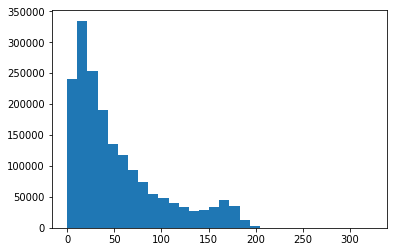

In [7]:
counts = []
for comment in x_train:
    counts.append(len(comment.split()))
_ = plt.hist(counts, bins=30)

Given the distribution above, the maximum lenght will be set to 200.

In [8]:
MAX_LEN = 200
tokenizer = Tokenizer()
tokenizer.fit_on_texts(list(x_train) + list(x_test))

<a name='3'></a>
# 3. Embeddings

Import the embeddings. These were obtained from the links mentioned above.

In [9]:
CRAWL_EMBEDDING_PATH = 'embeddings/crawl-300d-2M.vec/crawl-300d-2M.vec'
GLOVE_EMBEDDING_PATH = 'embeddings/glove/glove.840B.300d.txt'

In [10]:
def get_coefs(word, *arr):
    return word, np.asarray(arr, dtype='float32')

def load_embeddings(path):
    with open(path, encoding="utf8") as f:
        return dict(get_coefs(*line.strip().split(' ')) for line in tqdm(f))

def build_matrix(word_index, path):
    embedding_index = load_embeddings(path)
    embedding_matrix = np.zeros((len(word_index) + 1, 300))
    unknown_words = []
    
    for word, i in word_index.items():
        try:
            embedding_matrix[i] = embedding_index[word]
        except KeyError:
            unknown_words.append(word)
    return embedding_matrix, unknown_words

Create matrices for each pre-trained embedding.

In [11]:
crawl_matrix, unknown_words_crawl = build_matrix(tokenizer.word_index, CRAWL_EMBEDDING_PATH)
print('n unknown words (crawl): ', len(unknown_words_crawl))

1999996it [03:59, 8347.25it/s]


n unknown words (crawl):  171860


In [12]:
glove_matrix, unknown_words_glove = build_matrix(tokenizer.word_index, GLOVE_EMBEDDING_PATH)
print('n unknown words (glove): ', len(unknown_words_glove))

2196017it [04:09, 8818.63it/s]


n unknown words (glove):  168567


Combininig the two matrices we get an embedding matrix with 600 dimensions for each word.

In [13]:
embedding_matrix = np.concatenate([crawl_matrix, glove_matrix], axis=-1)
print(embedding_matrix.shape)

del x_test
del crawl_matrix
del glove_matrix
gc.collect()

(325203, 600)


16

<a name='4'></a>
# 4. Train validation split

The dataset is split in two using stratification and random splitting. The validation set consists of 15% of the available training data. Moreover, the train and validation comments are tokenized.

In [14]:
train['comment_text'] = x_train
train['target_binary'] = (train['target'].values>=0.5).astype(np.int)

train_df, val_df = model_selection.train_test_split(train, test_size=0.15, stratify=train['target_binary'], random_state=40)
print('%d train comments, %d validation comments' % (len(train_df), len(val_df)))

x_train = sequence.pad_sequences(tokenizer.texts_to_sequences(train_df['comment_text']), maxlen=MAX_LEN)
x_val = sequence.pad_sequences(tokenizer.texts_to_sequences(val_df['comment_text']), maxlen=MAX_LEN)

1534142 train comments, 270732 validation comments


<a name='5'></a>
# 5. Target preprocessing

The metric used in this competition consists of a weighted sum between the overall AUC and the bias AUCs of the following three specific subsets:

Subgroup AUC: Here, we restrict the data set to only the examples that mention the specific identity subgroup. A low value in this metric means the model does a poor job of distinguishing between toxic and non-toxic comments that mention the identity.

BPSN  AUC: Here, we restrict the data to the non-toxic examples that mention the identity and the toxic examples that do not. A low value in this metric means that the model confuses non-toxic examples that mention the identity with toxic examples that do not, likely meaning that the model predicts higher toxicity scores than it should for non-toxic examples mentioning the identity.

BNSP  AUC: Here, we restrict the data set to the toxic examples that mention the identity and the non-toxic examples that do not. A low value here means that the model confuses toxic examples that mention the identity with non-toxic examples that do not, likely meaning that the model predicts lower toxicity scores than it should for toxic examples mentioning the identity.

In [15]:
identity_columns = [
    'male', 'female', 'homosexual_gay_or_lesbian', 'christian', 'jewish',
    'muslim', 'black', 'white', 'psychiatric_or_mental_illness']

def target_preprocessing(df):
    # Overall
    weights = np.ones((len(df['comment_text']),)) / 4
    # Subgroup
    weights += (df[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) / 4
    # Background Positive, Subgroup Negative
    weights += (( (df['target'].values>=0.5).astype(bool).astype(np.int) +
       (df[identity_columns].fillna(0).values<0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
    # Background Negative, Subgroup Positive
    weights += (( (df['target'].values<0.5).astype(bool).astype(np.int) +
       (df[identity_columns].fillna(0).values>=0.5).sum(axis=1).astype(bool).astype(np.int) ) > 1 ).astype(bool).astype(np.int) / 4
    loss_weight = 1.0 / weights.mean()

    y = np.vstack([(df['target'].values>=0.5).astype(np.int),weights]).T
    y_aux = df[['target', 'severe_toxicity', 'obscene', 'identity_attack', 'insult', 'threat']].values
    return y, y_aux, loss_weight

y_train, y_aux_train, train_weight = target_preprocessing(train_df)
y_val, y_aux_val, val_weight = target_preprocessing(val_df)

<a name='6'></a>
# 6. Model

A custom loss is implemented in which each target value is weighted by its importance given the definition above.

In [16]:
def custom_loss(y_true, y_pred):
    return BinaryCrossentropy()(tf.keras.backend.reshape(y_true[:,0],(-1,1)), y_pred) * y_true[:,1]

In [17]:
tf.keras.backend.clear_session()

def lstm_model(embedding_matrix, aux_target_shape, loss_weight):
    sequences = Input(shape=(MAX_LEN, ))
    x = Embedding(*embedding_matrix.shape,  
                    embeddings_initializer=Constant(embedding_matrix), 
                    trainable=False)(sequences)
    x = SpatialDropout1D(0.15)(x)
    x = Bidirectional(LSTM(256, dropout=0.1, return_sequences=True))(x)
    x = Bidirectional(LSTM(128, dropout=0.1, return_sequences=True))(x)
    
    x = Concatenate()([GlobalMaxPooling1D()(x), GlobalAveragePooling1D()(x)])
    
    dense1 = Dense(512, activation='selu')(x)
    x = Add()([dense1, x])
    
    dense2 = Dense(512, activation='selu')(x)
    x = Add()([dense2, x])

    result = Dense(1, activation='sigmoid')(x)
    aux_result = Dense(aux_target_shape, activation='sigmoid')(x)
    
    model = Model(inputs=sequences, outputs=[result, aux_result])

    model.compile(loss=[custom_loss, 'binary_crossentropy'], loss_weights=[loss_weight, 1.0], optimizer='adam')
    
    return model


model = lstm_model(embedding_matrix, y_aux_train.shape[-1], train_weight)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 200)]        0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 200, 600)     195121800   input_1[0][0]                    
__________________________________________________________________________________________________
spatial_dropout1d (SpatialDropo (None, 200, 600)     0           embedding[0][0]                  
__________________________________________________________________________________________________
bidirectional (Bidirectional)   (None, 200, 512)     1755136     spatial_dropout1d[0][0]          
______________________________________________________________________________________________

The model is trained for 2 epochs with the parameters below.

In [18]:
model.load_weights('lstm.h5')
# checkpoint = ModelCheckpoint('lstm.h5', monitor='val_loss', save_best_only=True, mode='min', save_weights_only=True)
# batch_size = 256
# train_history = model.fit(
#                         x_train,
#                         [y_train, y_aux_train],
#                         validation_data=(x_val, [y_val, y_aux_val]),
#                         batch_size = batch_size,
#                         epochs = 2,
#                         verbose = 2,
#                         callbacks=[checkpoint])

<a name='7'></a>
# 7. Results

The predicitions for the validation set are stored in the val_df dataframe to compute the corresponding metrics.

In [19]:
MODEL_NAME = 'my_model'
predictions = model.predict(x_val)
val_df[MODEL_NAME] = predictions[0].flatten()

Define and compute each AUC metric.

In [20]:
from sklearn import metrics

TOXICITY_COLUMN = 'target_binary'
SUBGROUP_AUC = 'subgroup_auc'
BPSN_AUC = 'bpsn_auc'  # stands for background positive, subgroup negative
BNSP_AUC = 'bnsp_auc'  # stands for background negative, subgroup positive

def compute_auc(y_true, y_pred):
    try:
        return metrics.roc_auc_score(y_true, y_pred)
    except ValueError:
        return np.nan

def compute_subgroup_auc(df, subgroup, label, model_name):
    subgroup_examples = df.loc[df[subgroup].astype(bool)]
    return compute_auc(subgroup_examples[label], subgroup_examples[model_name])

def compute_bpsn_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup negative examples and the background positive examples."""
    subgroup_negative_examples = df.loc[df[subgroup].astype(bool) & ~df[label].astype(bool)]
    non_subgroup_positive_examples = df.loc[~df[subgroup].astype(bool) & df[label].astype(bool)]
    examples = subgroup_negative_examples.append(non_subgroup_positive_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bnsp_auc(df, subgroup, label, model_name):
    """Computes the AUC of the within-subgroup positive examples and the background negative examples."""
    subgroup_positive_examples = df.loc[df[subgroup].astype(bool) & df[label].astype(bool)]
    non_subgroup_negative_examples = df.loc[~df[subgroup].astype(bool) & ~df[label].astype(bool)]
    examples = subgroup_positive_examples.append(non_subgroup_negative_examples)
    return compute_auc(examples[label], examples[model_name])

def compute_bias_metrics_for_model(dataset,
                                   subgroups,
                                   model,
                                   label_col,
                                   include_asegs=False):
    """Computes per-subgroup metrics for all subgroups and one model."""
    records = []
    for subgroup in subgroups:
        record = {
            'subgroup': subgroup
        }
        record[SUBGROUP_AUC] = compute_subgroup_auc(dataset, subgroup, label_col, model)
        record[BPSN_AUC] = compute_bpsn_auc(dataset, subgroup, label_col, model)
        record[BNSP_AUC] = compute_bnsp_auc(dataset, subgroup, label_col, model)
        records.append(record)
    return pd.DataFrame(records).sort_values('subgroup_auc', ascending=True)

bias_metrics_df = compute_bias_metrics_for_model(val_df, identity_columns, MODEL_NAME, TOXICITY_COLUMN)
bias_metrics_df

,bnsp_auc,bpsn_auc,subgroup,subgroup_auc
1,0.952728,0.968552,female,0.969390
0,0.953986,0.967405,male,0.969428
5,0.952031,0.970172,muslim,0.969597
7,0.955440,0.967720,white,0.969624
3,0.947984,0.970878,christian,0.969920
6,0.954075,0.968254,black,0.970118
2,0.952800,0.968948,homosexual_gay_or_lesbian,0.970353
4,0.949755,0.970760,jewish,0.970527
8,0.950957,0.969780,psychiatric_or_mental_illness,0.970763


In [21]:
def calculate_overall_auc(df, model_name):
    true_labels = val_df['target_binary']
    predicted_labels = df[model_name]
    return metrics.roc_auc_score(true_labels, predicted_labels)

def power_mean(series, p):
    total = sum(np.power(series, p))
    return np.power(total / len(series), 1 / p)

def get_final_metric(bias_df, overall_auc, POWER=-5, OVERALL_MODEL_WEIGHT=0.25):
    bias_score = np.average([
        power_mean(bias_df[SUBGROUP_AUC], POWER),
        power_mean(bias_df[BPSN_AUC], POWER),
        power_mean(bias_df[BNSP_AUC], POWER)
    ])
    return (OVERALL_MODEL_WEIGHT * overall_auc) + ((1 - OVERALL_MODEL_WEIGHT) * bias_score)
    
AUC = get_final_metric(bias_metrics_df, calculate_overall_auc(val_df, MODEL_NAME))

Plot the ROC curve for the validation set.

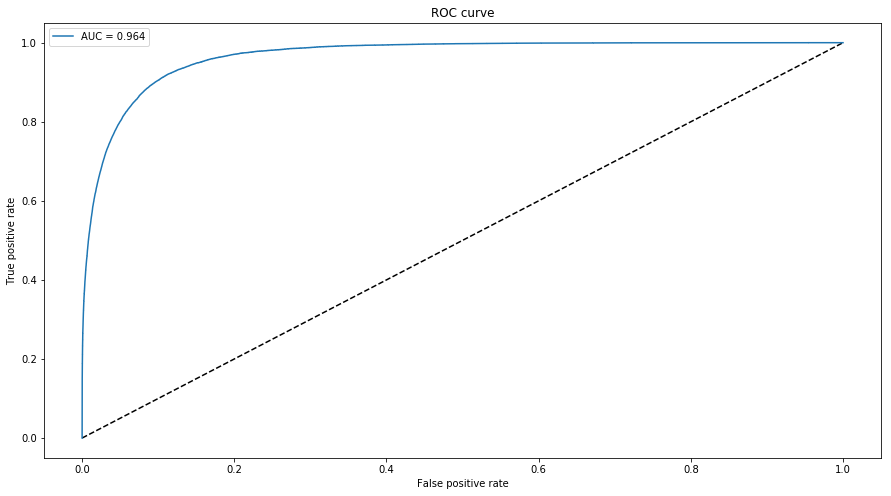

In [22]:
from sklearn.metrics import roc_curve
fpr, tpr, thresholds = roc_curve(val_df['target_binary'], predictions[0].flatten())

plt.figure(figsize=(15,8))
plt.plot([0, 1], [0, 1], 'k--')
plt.plot(fpr, tpr, label='AUC = {:.3f}'.format(AUC))
plt.xlabel('False positive rate')
plt.ylabel('True positive rate')
plt.title('ROC curve')
plt.legend(loc='best')
plt.show()